In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pickle
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

# df = pd.read_csv('data/2020 Line 280 AVL report.csv')
df = pd.read_csv('data/2019 Line 280 AVL allscripts.csv')
df['Actual Depart Hour'] = df['Actual Depart'].str.split(':',expand=True)[0]
df['Actual Depart Hour'] = df['Actual Depart Hour'].astype(int)
df['Transit Date Month'] = df['Transit Date'].str.split('/',expand=True)[0]
df['Transit Date Month'] = df['Transit Date Month'].astype(int)

C:\Users\schub\AppData\Local\Temp/ipykernel_17488/349049247.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
C:\Users\schub\AppData\Local\Temp/ipykernel_17488/349049247.py:35: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train


Wall time: 413 ms


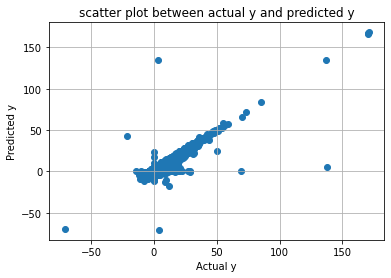

Mean Squared Error : 4.182341788507738
Mean Absolute Error : 0.9791534726828787
[0.87139813 0.91528891 0.72853247 0.90637216 0.81464928]
0.85 accuracy with a standard deviation of 0.07


In [11]:
# df1 = df.copy()
# df1 = df.loc[(df['Bus Stop ID'] == 775) | (df['Bus Stop ID'] == 782) | (df['Bus Stop ID'] == 733)]
df1 = df.loc[(df['Bus Stop ID'] != 177)]
df1 = df1.loc[(df1['Bus Stop ID'] != 738)]
df1 = df1.loc[(df1['Bus Stop ID'] != 2199)]
df1 = df1.loc[(df1['Bus Stop ID'] != 2384)]

df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
    'Miles from Prior Time Point', 'Bus Stop ID'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
        'Enc_Miles_', 'Enc_Stop_'])
# df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
#     'Miles from Prior Time Point'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
#         'Enc_Miles_'])
# df1 = pd.get_dummies(df1, columns=['Transit Date Month'],prefix=['Enc_Month_'])

# df1['Transit Date Month'] = df1['Transit Date'].str.split('/',expand=True)[0]
df1.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df1['Difference (Minutes)'] = df1['Difference (Minutes)'].astype(int)
df1['Prev Departure Offset'] = df1['Prev Departure Offset'].astype(int)
# df1['Transit Date Month'] = df1['Transit Date Month'].astype(int)

# df.replace('?', -99999, inplace=True) #sees -99999 as outlier, ignores it
df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
        'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Actual Run Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period', 'Scheduled Run Time',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset'\
                                ], 1, inplace=True)
# print(df1.head)
# pd.to_numeric(df1['Actual Operating Speed'], errors='coerce')
X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train
Y = np.array(df1['Difference (Minutes)']) #class is the final result obviously
np.nan_to_num(X)
np.nan_to_num(Y)
pd.isnull(X)
np.nan_to_num(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# lr_sgd = SGDRegressor(penalty='elasticnet')
lr_sgd = SGDRegressor(loss='huber', penalty='elasticnet')
%time lr_sgd.fit(X_train, Y_train)

filename = 'models/2019_lr_sgd_model_9_15.sav'
pickle.dump(lr_sgd, open(filename, 'wb'))

plt.scatter(Y_test, lr_sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print('Mean Squared Error :',mean_squared_error(Y_test, lr_sgd.predict(X_test)))
print('Mean Absolute Error :',mean_absolute_error(Y_test, lr_sgd.predict(X_test)))

scores = cross_val_score(lr_sgd, X_test, Y_test, cv=5)

print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)
# ax.plot(X_train, clf.fit(X_train, Y_train).predict(X_train), lw=2)
# ax.scatter(X_train[clf.support_], Y_train[clf.support_], facecolor="none",s=50)
# # ax.scatter(X_test[np.setdiff1d(np.arange(len(X_test)),clf.support_)],
# #            Y_test[np.setdiff1d(np.arange(len(X_test)), clf.support_)],
# #            facecolor="none", edgecolor="k", s=50)


# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()

In [12]:

# df1 = df.copy()
# df1 = df.loc[(df['Bus Stop ID'] == 775) | (df['Bus Stop ID'] == 782) | (df['Bus Stop ID'] == 733)]





#################################################################################
# df1 = df.loc[(df['Bus Stop ID'] != 177)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 738)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 2199)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 2384)]

# df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
#     'Miles from Prior Time Point', 'Bus Stop ID'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
#         'Enc_Miles_', 'Enc_Stop_'])
# # df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
# #     'Miles from Prior Time Point'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
# #         'Enc_Miles_'])
# # df1 = pd.get_dummies(df1, columns=['Transit Date Month'],prefix=['Enc_Month_'])

# # df1['Transit Date Month'] = df1['Transit Date'].str.split('/',expand=True)[0]
# df1.fillna(value = -9999)
# enc = OneHotEncoder(handle_unknown='ignore')

# df1['Difference (Minutes)'] = df1['Difference (Minutes)'].astype(int)
# df1['Prev Departure Offset'] = df1['Prev Departure Offset'].astype(int)
# # df1['Transit Date Month'] = df1['Transit Date Month'].astype(int)

# # df.replace('?', -99999, inplace=True) #sees -99999 as outlier, ignores it
# df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
#     'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
#         'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
#             'Dwell Time', 'Actual Run Time', 'Scheduled Operating Speed','Actual Operating Speed',\
#                 'Run Time Variance','Day Type','Time Period', 'Scheduled Run Time',\
#                         'Scheduled Depart DateTime', 'Actual Depart DateTime', \
#                             'Same Stop Prev Trip Departure Offset'\
#                                 ], 1, inplace=True)
# print(df1.head)
# # pd.to_numeric(df1['Actual Operating Speed'], errors='coerce')
# X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train
# Y = np.array(df1['Difference (Minutes)']) #class is the final result obviously
# np.nan_to_num(X)
# np.nan_to_num(Y)
# pd.isnull(X)
# np.nan_to_num(X)

# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# clf = svm.SVR()
# %time clf.fit(X_train, Y_train)

# scores = cross_val_score(clf, X_test, Y_test, cv=5)

# print(scores)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
#################################################################################





# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)
# ax.plot(X_train, clf.fit(X_train, Y_train).predict(X_train), lw=2)
# ax.scatter(X_train[clf.support_], Y_train[clf.support_], facecolor="none",s=50)
# # ax.scatter(X_test[np.setdiff1d(np.arange(len(X_test)),clf.support_)],
# #            Y_test[np.setdiff1d(np.arange(len(X_test)), clf.support_)],
# #            facecolor="none", edgecolor="k", s=50)


# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()

C:\Users\schub\AppData\Local\Temp/ipykernel_17488/1053966374.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
C:\Users\schub\AppData\Local\Temp/ipykernel_17488/1053966374.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train


<bound method NDFrame.head of         Difference (Minutes)  Prev Departure Offset  Enc_Hour__0  Enc_Hour__1  \
0                          2                      0            0            0   
1                          0                      2            0            0   
2                          0                      0            0            0   
3                          1                      0            0            0   
4                          1                      1            0            0   
...                      ...                    ...          ...          ...   
202608                     0                      0            0            0   
202609                     0                      0            0            0   
202610                     0                      0            0            0   
202611                     0                      0            0            0   
202612                     0                      0            0            0  

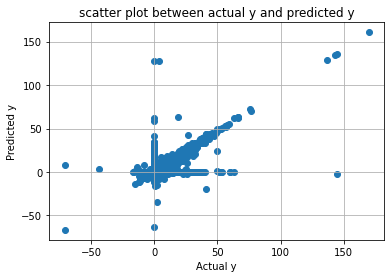

Mean Squared Error : 12.042894457313485
Mean Absolute Error : 1.5145422176648982
[0.58581794 0.36303206 0.63264148 0.59386645 0.45974159]
0.53 accuracy with a standard deviation of 0.10


In [13]:
df1 = df.copy()


df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week']\
    ,prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_'])

df1.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df1['Prev Departure Offset'] = df1['Prev Departure Offset'].astype(int)
df1['Difference (Minutes)'] = df1['Difference (Minutes)'].astype(int)

df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
   'Miles from Prior Time Point', 'Bus Stop ID',
        'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset', \
                                'Scheduled Run Time', 'Actual Run Time'], 1, inplace=True)
print(df1.head)
X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train
Y = np.array(df1['Difference (Minutes)']) #class is the final result obviously
np.nan_to_num(X)
np.nan_to_num(Y)
pd.isnull(X)
np.nan_to_num(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

lr_sgd = SGDRegressor(loss='huber')
%time lr_sgd.fit(X_train, Y_train)

filename = 'models/2019_lr_sgd_model_9_15.sav'
pickle.dump(lr_sgd, open(filename, 'wb'))

plt.scatter(Y_test, lr_sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print('Mean Squared Error :',mean_squared_error(Y_test, lr_sgd.predict(X_test)))
print('Mean Absolute Error :',mean_absolute_error(Y_test, lr_sgd.predict(X_test)))

scores = cross_val_score(lr_sgd, X_test, Y_test, cv=5)

print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

C:\Users\schub\AppData\Local\Temp/ipykernel_17488/3423238682.py:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set(Title="2019 Bus Run Time Correlation with Scheduled Run Time")
No handles with labels found to put in legend.


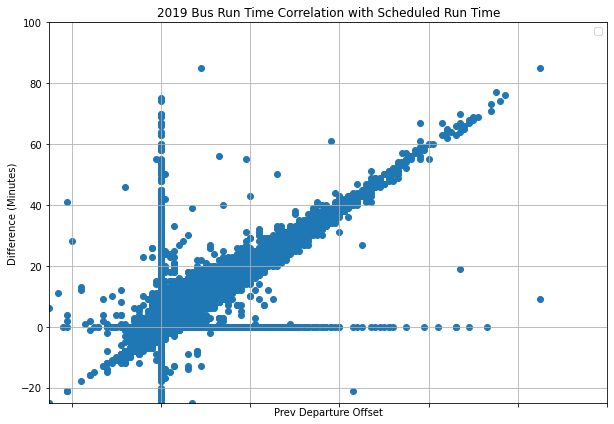

0.7539703524135235

In [14]:
stopactual = df
stopactual
stopactual['Prev Departure Offset'] = stopactual['Prev Departure Offset'].astype(int)
stopactual['Difference (Minutes)'] = stopactual['Difference (Minutes)'].astype(int)

f=plt.figure(figsize=(10,7))

ax1=f.add_subplot(111)
ax1.set_xlim(left = -25,right=100)
ax1.set_ylim(bottom=-25,top=100)
ax1.set(Title="2019 Bus Run Time Correlation with Scheduled Run Time")
# plt.ylim(0,15)
ax1.scatter(stopactual['Prev Departure Offset'], stopactual['Difference (Minutes)'])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend()
plt.grid()

ax1.set(xlabel="Prev Departure Offset")
ax1.set(ylabel="Difference (Minutes)")

locs, labels = plt.xticks() 



plt.show()

df['Prev Departure Offset'].corr(df['Difference (Minutes)'])

In [15]:
print(df.loc[df['Run Time Variance']==0].shape[0]/df.shape[0])

0.4404011588595006


<bound method NDFrame.head of         Difference (Minutes)  Scheduled Run Time  Actual Run Time  \
0                          2                   0                0   
1                          0                   8                6   
2                          0                   6                6   
3                          1                   9               10   
4                          1                   0                6   
...                      ...                 ...              ...   
202608                     0                   0                0   
202609                     0                   9                9   
202610                     0                   0               10   
202611                     0                   0                3   
202612                     0                   0                6   

        Enc_Hour__0  Enc_Hour__1  Enc_Hour__5  Enc_Hour__6  Enc_Hour__7  \
0                 0            0            0            0        

C:\Users\schub\AppData\Local\Temp/ipykernel_17488/2443813928.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(df2.drop(['Difference (Minutes)'],1)) #using everything except class to train


Wall time: 244 ms


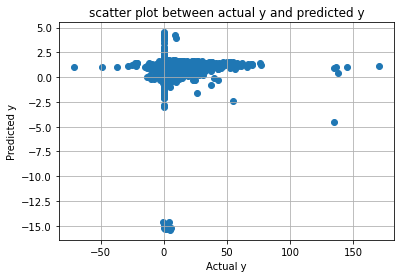

Mean Squared Error : 28.691979818771355
Mean Absolute Error : 2.6711774848911216
[-0.11274232 -0.1118398  -0.10452993 -0.08471488 -0.1051232 ]
-0.10 accuracy with a standard deviation of 0.01


In [19]:
df2 = df.copy()

df2 = pd.get_dummies(df2, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week']\
    ,prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_'])

df2.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df2['Scheduled Run Time'] = df2['Scheduled Run Time'].astype(int)
df2['Difference (Minutes)'] = df2['Difference (Minutes)'].astype(int)

df2.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
   'Miles from Prior Time Point', 'Bus Stop ID', \
        'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset', \
                                 'Prev Departure Offset'], axis = 1, inplace=True)
print(df2.head)
X = np.array(df2.drop(['Difference (Minutes)'],1)) #using everything except class to train
Y = np.array(df2['Difference (Minutes)']) #class is the final result obviously
np.nan_to_num(X)
np.nan_to_num(Y)
pd.isnull(X)
np.nan_to_num(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

lr_sgd = SGDRegressor(loss='huber')
%time lr_sgd.fit(X_train, Y_train)



plt.scatter(Y_test, lr_sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print('Mean Squared Error :',mean_squared_error(Y_test, lr_sgd.predict(X_test)))
print('Mean Absolute Error :',mean_absolute_error(Y_test, lr_sgd.predict(X_test)))

scores = cross_val_score(lr_sgd, X_test, Y_test, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
df.fillna(value = -999999)
df['Prev Departure Offset'] = df['Prev Departure Offset'].astype(float)
df['Difference (Minutes)'] = df['Difference (Minutes)'].astype(float)

model = smf.mixedlm('Q("Prev Departure Offset") ~ Q("Difference (Minutes)")',data = df,groups = "Bus Stop ID").fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:            MixedLM Dependent Variable: Q("Prev Departure Offset")
No. Observations: 202613  Method:             REML                      
No. Groups:       12      Scale:              8.9508                    
Min. group size:  10500   Log-Likelihood:     -509587.0694              
Max. group size:  23107   Converged:          Yes                       
Mean group size:  16884.4                                               
------------------------------------------------------------------------
                              Coef. Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     0.593    0.397   1.492 0.136 -0.186  1.372
Q("Difference (Minutes)")     0.755    0.001 569.641 0.000  0.753  0.758
Bus Stop ID Var               1.894    0.277                            
========================================================================

"""

C:\Users\schub\anaconda3\envs\ltc_project\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Residuals')

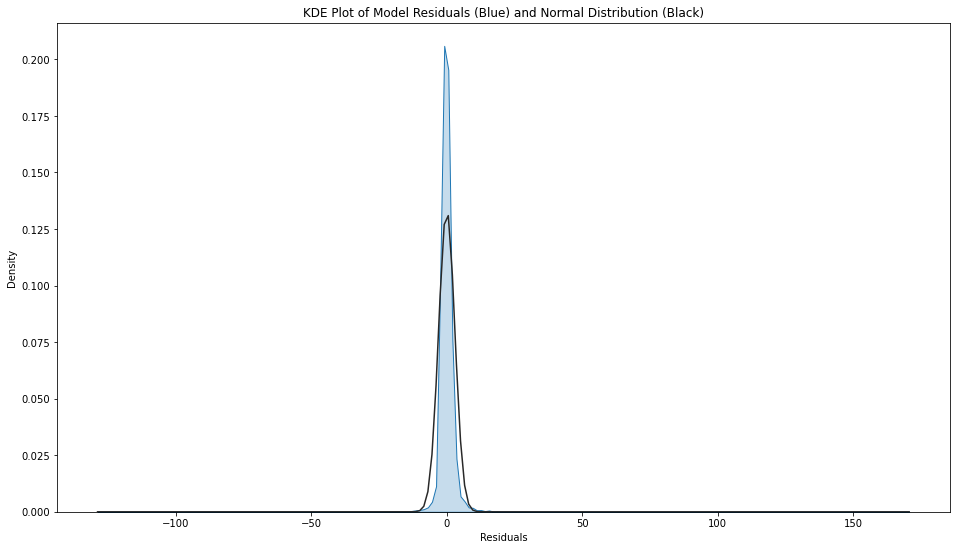

In [ ]:
fig = plt.figure(figsize = (16, 9))

ax = sns.distplot(model.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)

ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")

Text(0, 0.5, 'Difference (Minutes)')

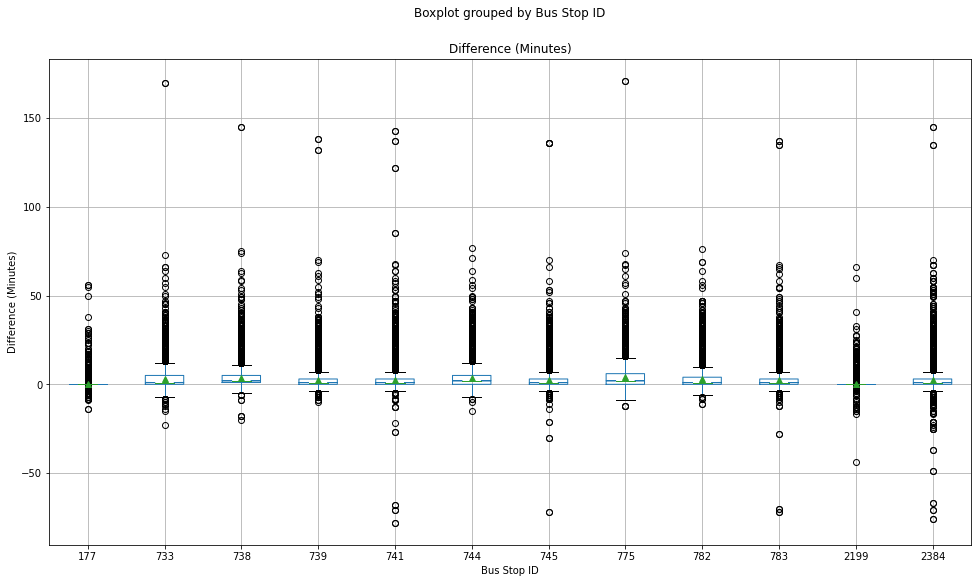

In [ ]:
boxplot = df.boxplot(["Difference (Minutes)"], by = ["Bus Stop ID"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Bus Stop ID")
boxplot.set_ylabel("Difference (Minutes)")

C:\Users\schub\anaconda3\envs\ltc_project\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 1.0, 'Difference (Minutes)')

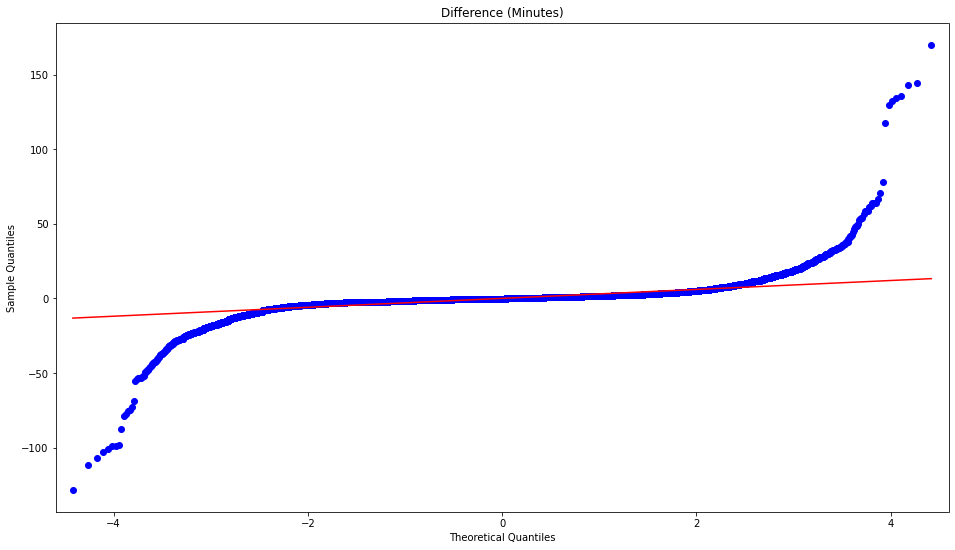

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(model.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Difference (Minutes)")